In [57]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.signal import lfilter
#import statistics as stats

In [58]:
import json
import math
import numpy as np
from scipy import signal
import h5py
import matplotlib.pyplot as plt
from matplotlib import rc
import datetime
import scipy.signal as signal
import pandas as pd
import seaborn as sns
import statistics as stats
from scipy.spatial.distance import hamming
import os

In [59]:
def text2bits(message):
    # Convert to characters of '1' and '0' in a vector.
    temp_message = []
    final_message = []
    for each in message:
        temp_message.append(format(ord(each), '07b'))
    for every in temp_message:
        for digit in every:
            final_message.append(int(digit))
    return final_message

In [60]:
def binvector2str(binvector):
    #binvector = binvector[0]
    length = len(binvector)
    eps = np.finfo('float').eps
    if abs(length/7 - round(length/7)) > eps:
        print('Length of bit stream must be a multiple of 7 to convert to a string.')
    # Each character requires 7 bits in standard ASCII
    num_characters = round(length/7)
    # Maximum value is first in the vector. Otherwise would use 0:1:length-1
    start = 6
    bin_values = []
    while start >= 0:
        bin_values.append(int(math.pow(2,start)))
        start = start - 1
    bin_values = np.array(bin_values)
    bin_values = np.transpose(bin_values)
    str_out = '' # Initialize character vector
    for i in range(num_characters):
        single_char = binvector[i*7:i*7+7]
        value = 0
        for counter in range(len(single_char)):
            value = value + (int(single_char[counter]) * int(bin_values[counter]))
        str_out += chr(int(value))
    return str_out

In [61]:
packet = 6000 # number of bits per pseudonym bit
samples = packet//10
OFDM_size = 80
CP = 16
mod_index = 0.2 # decides the level of modification/modulation on the host signal
#const = 0.02 # used to control voltage input to the usrp transmitter
Pseudonym = 'STOP'
Pseudonym_Len = len(text2bits(Pseudonym))

In [62]:
# PURPOSE: Generate an OFMD signal for a given text message
# We use 25% cyclic prefix
def OFDM_TX(x):
    #args = parse_args()
    K = 64 # number of OFDM subcarriers
    P = 4 # number of pilot carriers per OFDM block
    G = 12 # number of guard carriers
    CP = 16  # 25% Cyclic Prefix 
    M = 2 # bits per symbol (i.e. QPSK)
    
    # generate the host message signal
    bits = np.random.binomial(n=1, p=0.5, size=(x*9600,))
    dataCarriers = np.array([-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,
                         -5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
    pilotCarriers = np.array([-21,-7,7,21])
    guardCarriers = np.array([-32,-31,-30,-29,-28,-27,26,27,28,29,30,31])
 
    for i in range(len(bits)//(2*K)):
        
        data_bits = bits[i*2*K:(i+1)*2*K]

        # Convert serial data to parallel
        def Serial_to_Parallel(x):
            return x.reshape((K, M))
        parallel_bits = Serial_to_Parallel(data_bits)

        # mapping table
        ## maps data_bits into complex value IQ samples
        mapping_table = {
            (0,0) : 1.4142 + 1.4142j,
            (0,1) : -1.4142 + 1.4142j,
            (1,0) : 1.4142 - 1.4142j,
            (1,1) : -1.4142 - 1.4142j
        }

        # mapping
        def Mapping(x):
            return np.array([mapping_table[tuple(b)] for b in x])
        
        QPSK = Mapping(parallel_bits)

        # OFDM symbol generation
        def OFDM_symbol_gen(x):
            #pilot_value = np.array([1.5+1.5j, -1.5-1.5j, 1.5+1.5j, -1.5-1.5j])
            guard_band = np.array([0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j, 0+0j])
            
            symbol = np.zeros(K, dtype=np.complex64)
            symbol[dataCarriers] = x[dataCarriers]
            #symbol[pilotCarriers] = pilot_value
            symbol[guardCarriers] = guard_band
            return symbol
        OFDM_symbol = OFDM_symbol_gen(QPSK)
        
        # Generate time domain signal
        def IDFT(x, n=64):
            return np.fft.ifftshift(np.fft.ifft(x,n))
        
        OFDM_symbol_time = IDFT(OFDM_symbol)

        #adding cyclic prefix
        def addCP(x):
            cp = x[-CP:]              
            return np.hstack([cp, x]) 
        OFDM_withCP = 3*addCP(OFDM_symbol_time)
        #OFDM_withCP = addCP(OFDM_symbol)
        if i == 0:
            OFDM_swap = OFDM_withCP
        else:
            OFDM_signal = np.hstack([OFDM_swap, OFDM_withCP])
            OFDM_swap = OFDM_signal
    return OFDM_signal

In [63]:
## embedding the message signal on to the host signal
def Pseudonym_embedding(x,message):
    modulated_signal = np.zeros(len(x), dtype=np.complex64)
    for i in range(int(len(x)/packet)):
        OFDM_packet = x[i*packet:(i+1)*packet]
        trancated_signal = np.zeros(len(OFDM_packet), dtype=np.complex64)
        if message[i] == 1.0:
            for j in range(10):
                if j%2 == 0:
                    trancated_signal[j*samples:(j+1)*samples] = (1+mod_index)*OFDM_packet[j*samples:(j+1)*samples]
                else:
                    trancated_signal[j*samples:(j+1)*samples] = (1-mod_index)*OFDM_packet[j*samples:(j+1)*samples]
        else:
            for j in range(10):
                if j%2 == 0:
                    trancated_signal[j*samples:(j+1)*samples] = (1-mod_index)*OFDM_packet[j*samples:(j+1)*samples]
                else:
                    trancated_signal[j*samples:(j+1)*samples] = (1+mod_index)*OFDM_packet[j*samples:(j+1)*samples]
        modulated_signal[i*packet:(i+1)*packet] = trancated_signal
    return modulated_signal

Length of OFDM signal: 168000
length of PAM modulated signal: 168000


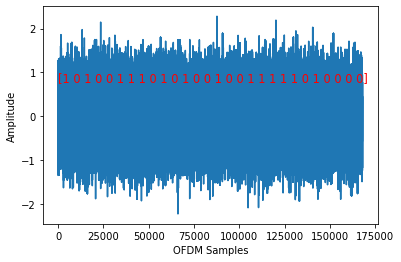

[1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0]


In [64]:
##########################################################################
# Generate PAM modulated OFDM signal 
##########################################################################
# pseudonym message = 'STOP'
# Because we use 25% cyclic prefixing, the required number of data_symbols is 4800
OFDM_signal = OFDM_TX(Pseudonym_Len) # 9600/2 is the number of data_symbols/per Pseudonym bit
print("Length of OFDM signal:",len(OFDM_signal))
PAM_modulated_OFDM = Pseudonym_embedding(OFDM_signal,text2bits(Pseudonym))
print("length of PAM modulated signal:",len(PAM_modulated_OFDM))

plt.plot(np.real(PAM_modulated_OFDM))
plt.ylabel("Amplitude")
plt.xlabel("OFDM Samples")
plt.text(0,0.8,"[1 0 1 0 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0]", fontsize = 11.4, c ='r')

plt.savefig("Watermarked_OFDM_signal.pdf")
plt.show()

print(text2bits(Pseudonym))

In [65]:
def Calculate_mean(x):
    swap = np.zeros(10,)
    for i in range(10):
        swap[i] = sum(abs(x[i*samples:(i+1)*samples])**2)/samples
    return np.mean(swap), swap

Mean power is: 0.46090942161836823


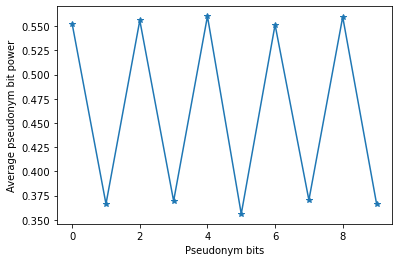

In [66]:
mean_power, power = Calculate_mean(PAM_modulated_OFDM)
print('Mean power is:',mean_power)
plt.plot(power,marker = '*')
plt.ylabel("Average pseudonym bit power")
plt.xlabel("Pseudonym bits")
plt.show()

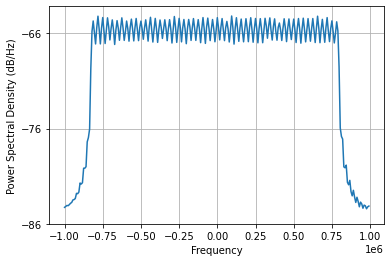

In [67]:
plt.psd(PAM_modulated_OFDM, Fs = 2e6)#, Fc = 3655e6)
plt.show()

## Add preamble for sample synchronization

In [68]:
# PURPOSE: Convert binary data to M-ary by making groups of log2(M)
#          bits and converting each bit to one M-ary digit.
# INPUT: Binary digit vector, with length as a multiple of log2(M)
# OUTPUT: M-ary digit vector
def binary2mary(data, M):

    log2M   = round(np.log2(M))
    # integer number of bits per group
    if (len(data) % log2M) != 0:
        print('Input to binary2mary must be divisible by log2(m).')
    data.shape = (len(data)//log2M, log2M)
    binaryValuesArray = 2**np.arange(log2M)
    marydata = data.dot(binaryValuesArray)
    return marydata

In [69]:
# PURPOSE: convert input data stream to signal space values for
#          a particular modulation type (as specified by the inputVec
#          and outputVec).
# INPUT: data (groups of bits)
# OUTPUT: signal space values
def lut(data, inputVec, outputVec):
    if len(inputVec) != len(outputVec):
        print('Input and Output vectors must have identical length')
    # Initialize output
    output = np.zeros(data.shape)
    # For each possible data value
    eps = np.finfo('float').eps
    for i in range(len(inputVec)):
        # Find the indices where data is equal to that input value
        for k in range(len(data)):
            if abs(data[k]-inputVec[i]) < eps:
                # Set those indices in the output to be the appropriate output value.
                output[k] = outputVec[i]
    return output

In [70]:
# PURPOSE: insert 0's between samples to oversample at OS_Rate
# INPUT: x (data), OS_Rate (how frequently data occurs)
# OUTPUT: x_s (oversampled data)
def oversample(x, OS_Rate):
    # Initialize output
    length = len(x[0])
    x_s = np.zeros((1,length*OS_Rate))
    # Fill in one out of every OS_Rate samples with the input values
    count = 0
    h = 0
    for k in range(len(x_s[0])):
        count = count + 1
        if count == OS_Rate:
            x_s[0][k] = x[0][h]
            count = 0
            h = h + 1
    return x_s

In [71]:
# PURPOSE: create a square root raised cosine pulse shape
# INPUT: alpha, N, Lp
# OUTPUT: pulse wave array for srrc
def SRRC(alpha, N, Lp):
    # Add epsilon to the n values to avoid numerical problems
    n = np.arange(-N*Lp+ (1e-9), N*Lp+1)
    h = np.zeros(len(n))
    coeff = 1/np.sqrt(N)
    for i, each in enumerate(n):
        sine_term = np.sin(np.pi * each * (1-alpha) / N)
        cosine_term = np.cos(np.pi * each * (1+alpha) / N)
        cosine_coeff = 4 * alpha * each / N
        numerator = sine_term + (cosine_coeff * cosine_term)
        denom_coeff = np.pi * each / N
        denom_part = 1 - cosine_coeff**2
        denominator = denom_coeff * denom_part
        h[i] = coeff * numerator / denominator
    return h

In [72]:
# PURPOSE: create a modulated signal with the defined preamble
# INPUT: A (sqrt value for modulation), N, alpha, Lp (for srrc)
# OUTPUT: modulated preamble signal & srrc pulse
def createPreambleSignal(A, N, alpha, Lp):

    # We defined the preamble as this repeating bit signal:
    preamble     = np.tile([1, 1, 0, 0], 16)

    ###########################################
    ### Signal Generation
    ### INPUT: binary data
    ### OUTPUT: 4-ary data (0..3) values
    data = binary2mary(preamble, 4)

    ###########################################
    ### Modulation
    ### INPUT: data
    ### OUTPUT: modulated values, x
    inputVec   = [0, 1, 2, 3]
    outputVecI = [A, -A, A, -A]
    outputVecQ = [A, A, -A, -A]
    xI         = lut(data, inputVec, outputVecI)
    xQ         = lut(data, inputVec, outputVecQ)
    xI = xI.reshape((1,len(data)))
    xQ = xQ.reshape((1,len(data)))
    ###########################################
    ### Upsample
    ### INPUT: modulated values, x
    ### OUTPUT: modulated values at sampling rate, x_s
    x_s_I = oversample(xI, N)
    x_s_Q = oversample(xQ, N)

    ###########################################
    ### Pulse-shape filter
    ### INPUT: modulated values at sampling rate, x_s
    ### OUTPUT: baseband transmit signal s

    pulse = SRRC(alpha, N, Lp)
    pulse = np.array(pulse)
    pulse = np.reshape(pulse, pulse.size)
    x_s_I = np.reshape(x_s_I, x_s_I.size)
    x_s_Q = np.reshape(x_s_Q, x_s_Q.size)
    s_0_I = np.convolve(x_s_I, pulse, mode='full')
    s_0_Q = np.convolve(x_s_Q, pulse, mode='full')
    plt.figure()
    plt.plot(pulse,label='SRRC pulse shape')
    plt.legend()
    plt.show()
    
    preamb = s_0_I + 1j*s_0_Q
    ## Add zero-padding at the beginning
    ##preamb = np.insert(s,0,np.zeros(1024))
    
    plt.figure()
    plt.plot(np.real(preamb),label='Real Signal')
    plt.plot(np.imag(preamb),label='Imag Signal')
    plt.grid('on')
    plt.legend()
    plt.show()
    return preamb, pulse

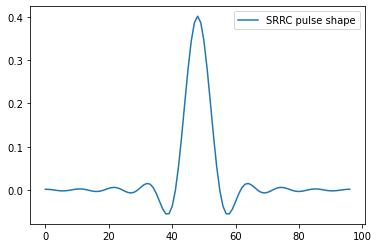

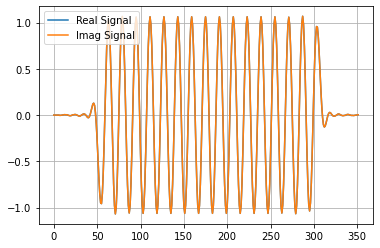

352


(0.58335745-0.58335745j)

In [73]:
A = np.sqrt(9/2)
N = 8
alpha = 0.5
Lp = 6
preambleSignal,pulse = createPreambleSignal(A, N, alpha, Lp)
print(len(preambleSignal))
PAM_modulated_OFDM[0]

In [74]:
# Concatenate preamble signal and pam modulated ofdm signal
PAM_modulated_OFDM_Final1 = np.concatenate((1.5*preambleSignal,PAM_modulated_OFDM))
print(len(PAM_modulated_OFDM_Final1))

168352


## Add zero padding at the beginning of the signal

In [75]:
PAM_modulated_OFDM_Final = np.hstack([np.zeros(1024, dtype=type(PAM_modulated_OFDM_Final1[0])),PAM_modulated_OFDM_Final1])
print(len(PAM_modulated_OFDM_Final))

169376


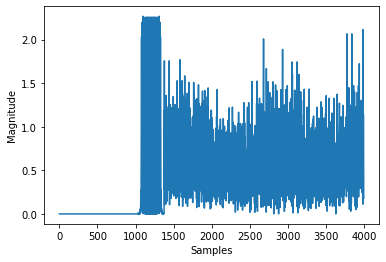

In [76]:
plt.plot(abs(PAM_modulated_OFDM_Final[:4000]))
plt.ylabel("Magnitude")
plt.xlabel("Samples")
plt.show()

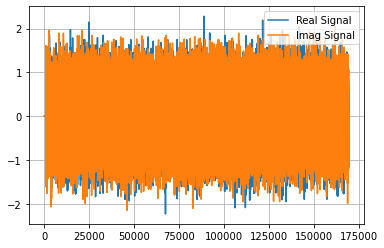

In [77]:
    plt.figure()
    plt.plot(np.real(PAM_modulated_OFDM_Final),label='Real Signal')
    plt.plot(np.imag(PAM_modulated_OFDM_Final),label='Imag Signal')
    plt.grid('on')
    plt.legend()
    plt.show()

In [78]:
# The SDR transmits IQ samples as IQIQIQ... patern 
# Convert complex to binary
def write_complex_binary(data, filename):
    '''
    Open filename and write array to it as binary
    Format is interleaved float IQ e.g. each I,Q should be 32-bit float 
    INPUT
    ----
    data:     data to be wrote into the file. format: (length, )
    filename: file name
    '''

    re = np.real(data)
    im = np.imag(data)
    binary = np.zeros(len(data)*2, dtype=np.float32)
    binary[::2] = re
    binary[1::2] = im
    binary.tofile(filename) 

In [79]:
# save generated signal to file
#write_complex_binary(PAM_modulated_OFDM_Final, 'TX_watermark_June_2024.iq')

In [80]:
print(len(PAM_modulated_OFDM_Final))

169376


# Check if our signal is correctly generated
# We have the receiver code below

In [81]:
# PURPOSE: perform preamble synchronization
#          Uses the (complex-valued) preamble signal. The cross-correlation 
#          of the preamble signal and the received signal (at the time
#          when the preamble is received) should have highest magnitude
#          at the index delay where the preamble approximately starts.  
# INPUT:   rx0: received signal (with a frequency offset)
#          preambleSignal: complex, known, transmitted preamble signal 
# OUTPUT:  lagIndex: the index of rx0 where the preamble signal has highest 
#              cross-correlation
#
def crossCorrelationMax(rx0, preambleSignal):

    # Cross correlate with the preamble to find it in the noisy signal
    lags      = signal.correlation_lags(len(rx0), len(preambleSignal), mode='valid')
    xcorr_out = signal.correlate(rx0, preambleSignal, mode='valid')
    xcorr_mag = np.abs(xcorr_out)
    # Don't let it sync to the end of the packet.
    packetLenSamples = 0#Pseudonym_Len*6000
    maxIndex = np.argmax(xcorr_mag[:len(xcorr_mag)-packetLenSamples])
    lagIndex = lags[maxIndex]

    print('Max crosscorrelation with preamble at lag ' + str(lagIndex))

    # Plot the selected signal.
    plt.figure()
    fig, subfigs = plt.subplots(2,1)
    subfigs[0].plot(np.real(rx0), label='Real RX Signal')
    subfigs[0].plot(np.imag(rx0), label='Imag RX Signal')
    scale_factor = np.mean(np.abs(rx0))/np.mean(np.abs(preambleSignal))
    subfigs[0].plot(range(lagIndex, lagIndex + len(preambleSignal)), scale_factor*np.real(preambleSignal), label='Preamble')
    subfigs[0].legend()
    subfigs[1].plot(lags, xcorr_mag, label='|X-Correlation|')
    plt.xlabel('Sample Index', fontsize=14)
    plt.tight_layout()

    return lagIndex

Max crosscorrelation with preamble at lag 1024


<Figure size 432x288 with 0 Axes>

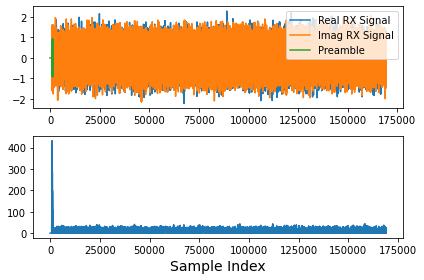

In [82]:
lagIndex = crossCorrelationMax(PAM_modulated_OFDM_Final,preambleSignal)


In [83]:
## Make p-bit decisions by comparing patterns on bit-0 and bit-1
def Matched_Filter_Pseudonym_Detection_Algorithm(x):
    print('Length of x:', len(x))
    matching_filter =np.array([1,-1,1,-1,1,-1,1,-1,1,-1])
    p_bit = []
    for i in range(28):
        pbit_data = x[i*packet:(i+1)*packet] # slices samples into one p-bit data
        
        power = []
        for j in range(10):
            chip_data = pbit_data[j*samples:(j+1)*samples]
            power.append(sum(abs(chip_data)**2))
       
        plt.plot(power)
        plt.show()
        
        threshold = 0.0
        quantization_level = np.array([1,-1])
        for k in range(9):
            if power[k] > power[k+1]:
                power[k] = quantization_level[0]
            else:
                power[k] = quantization_level[1]
        if power[8] < power[9]:
            power[9] = quantization_level[0]
        else:
            power[9] = quantization_level[1]
            
        pseudonym_power = np.dot(power,matching_filter)        

        if pseudonym_power > threshold:
            p_bit.append(1)
        else:
            p_bit.append(0)  
    return np.array(p_bit)

Length of x: 168000


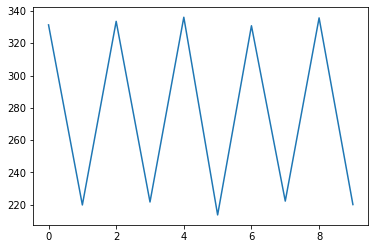

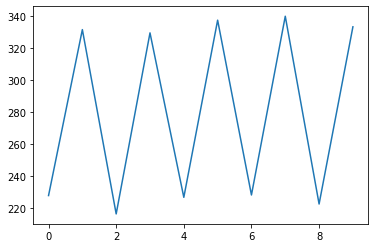

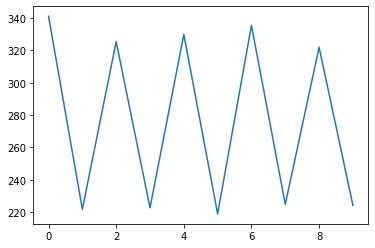

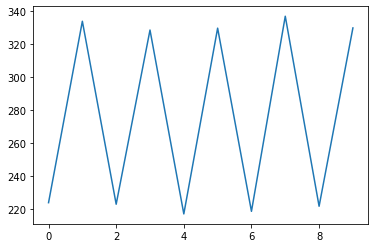

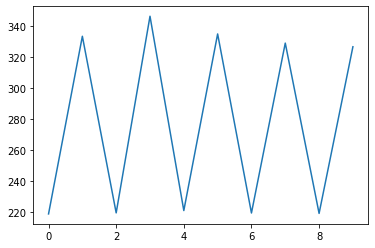

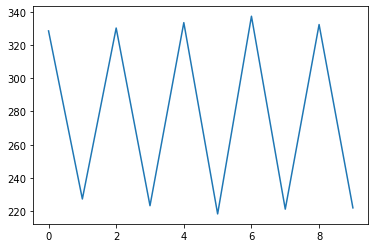

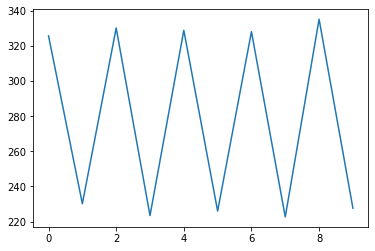

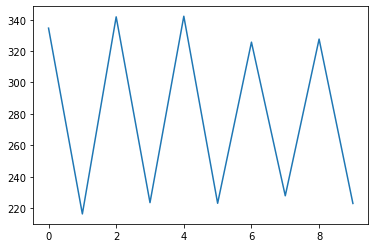

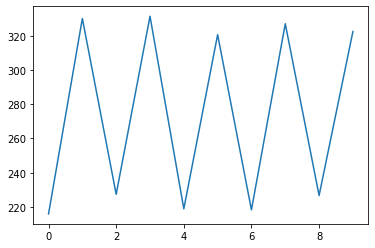

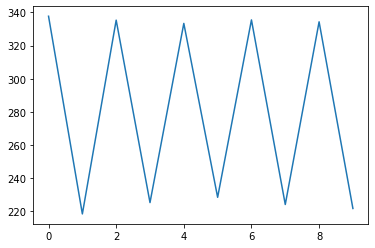

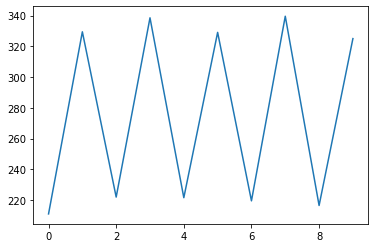

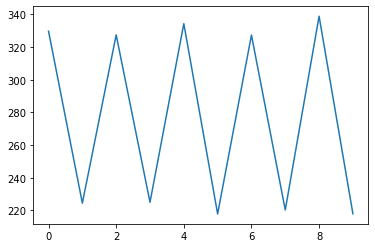

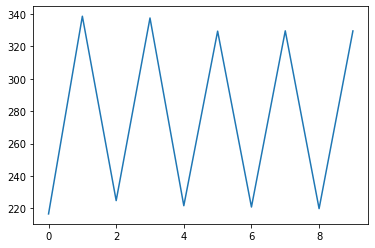

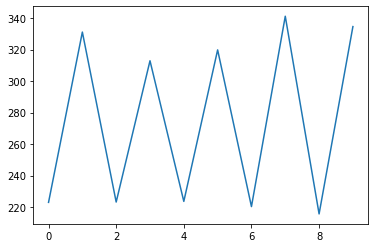

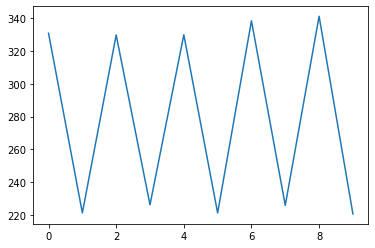

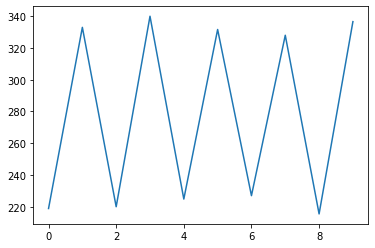

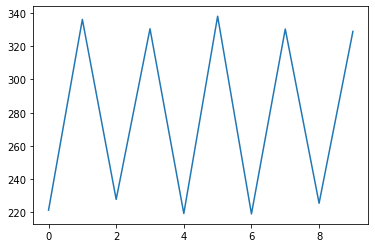

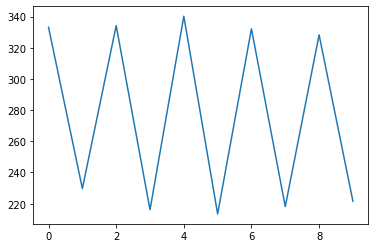

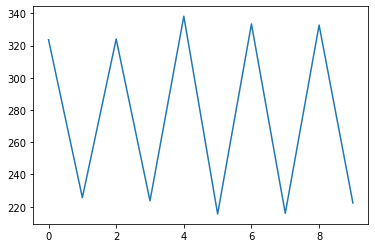

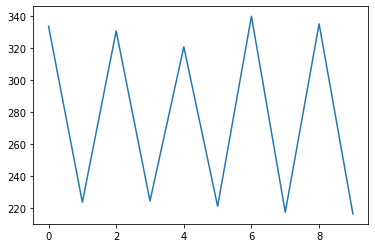

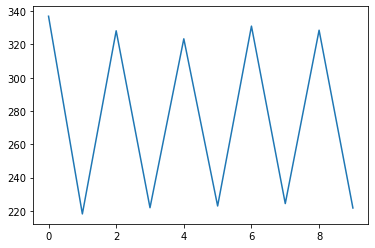

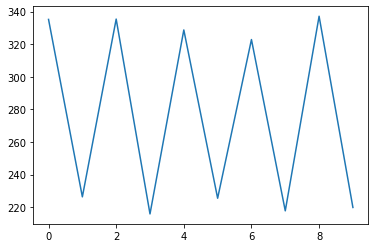

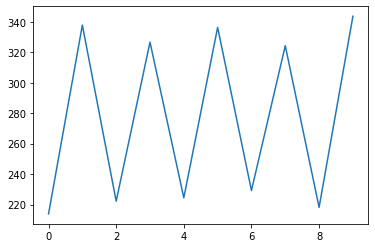

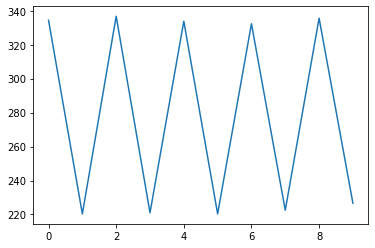

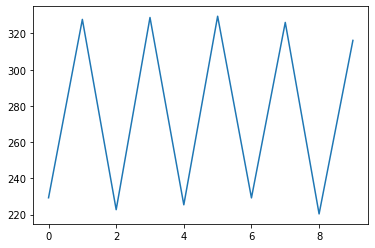

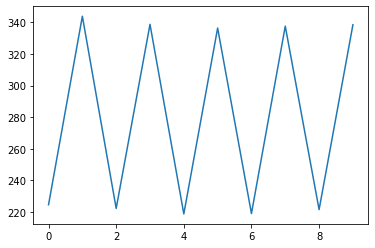

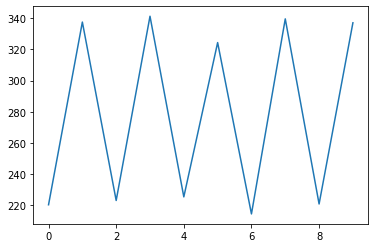

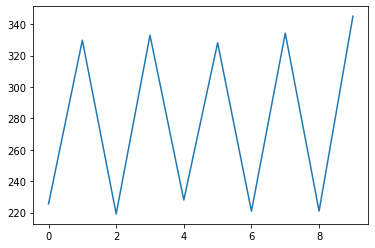

The detected pseudonym message is: STOP


In [84]:
start_of_data = lagIndex + len(preambleSignal)
pseudonym_estimate = Matched_Filter_Pseudonym_Detection_Algorithm(PAM_modulated_OFDM_Final[start_of_data:])

print('The detected pseudonym message is:', binvector2str(pseudonym_estimate))
